# CVaR-based MPC vs Nominal MPC: Training and Evaluation Comparison

This notebook compares two control strategies for wine fermentation using a training-then-evaluation approach:
1. **Nominal MPC**: Uses nominal (mean) cellar temperature, ignoring uncertainty
2. **CVaR-based MPC**: Risk-averse optimization considering worst-case scenarios

**Methodology:**
- **Training Phase**: Both controllers compute optimal 21-day control trajectories (open-loop)
- **Evaluation Phase**: Apply fixed control trajectories to multiple test scenarios with varying cellar temperatures
- **Comparison**: Statistical analysis of objective function values, final states, and constraint violations

The cellar temperature p[17] varies uniformly, representing ambient temperature uncertainty.

## Import Libraries

In [61]:
from time import time
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime


# Random number generatorsrng_test = np.random.default_rng(999)       # For evaluation test scenarios
rng_training = np.random.default_rng(42)    # For CVaR training scenarios

## Configuration Parameters

In [62]:
# ============================================================================
# KINETIC PARAMETERS FOR OENOFERM FREDDO YEAST
# ============================================================================
p_fred = [2.86655, 0.2868, 3.8406, 56.6794, 1.29881, 36.2122, 1.93209, 682.807, 
          5.27951, 2.73182e-06, 0.165704, 0.0020808, 0.0224764, 2.30538, 0.029611, 
          0.00130657, 59.8368, 14.5, 2.0, (23.5/180 *0.8 *178.9)/95, 1.0, 
          0.15841, 0.0434, 0.137399, 0.0577448]

# ============================================================================
# UNCERTAINTY CONFIGURATION 
# ============================================================================
T_cellar_min = 10.0         # Minimum ambient temperature (°C) 
T_cellar_max = 28.0         # Maximum ambient temperature (°C) - wider spread for stronger uncertainty
T_cellar_nominal = 14.5     # Nominal temperature for deterministic MPC (midpoint of range)

p_fred[22] = 0.5  # Double ambient cooling influence to amplify temperature impact on fermentation

# ============================================================================
# CVAR CONFIGURATION
# ============================================================================
alpha = 0.05                    # CVaR confidence level (5% tail risk)
n_training_scenarios = 50       # Number of scenarios for CVaR training optimization

# ============================================================================
# MPC CONFIGURATION
# ============================================================================
th = 1          # Time step (days)
n = 21          # Prediction horizon (days)

# ============================================================================
# EVALUATION CONFIGURATION
# ============================================================================
n_test_scenarios = 100  # Number of test scenarios for evaluation (configurable)

# ============================================================================
# INITIAL CONDITIONS
# ============================================================================
y0_initial = DM([0.20, 0.098, 0.0, 178.9, 0.005, 18])  # [X, N, E, S, O, T]
Sref_target = DM([0])  # Target sugar concentration

print(f"Configuration loaded:")
print(f"  Training: CVaR uses {n_training_scenarios} scenarios, α={alpha}")
print(f"  Evaluation: {n_test_scenarios} test scenarios")
print(f"  Uncertainty: T_cellar ∈ [{T_cellar_min}, {T_cellar_max}]°C")

Configuration loaded:
  Training: CVaR uses 50 scenarios, α=0.05
  Evaluation: 100 test scenarios
  Uncertainty: T_cellar ∈ [10.0, 28.0]°C


## Define Common System Dynamics

In [63]:
# ============================================================================
# STATE VARIABLES
# ============================================================================
X = SX.sym('X')  # Yeast concentration (g/L)
N = SX.sym('N')  # Nitrogen concentration (g/L)
E = SX.sym('E')  # Ethanol concentration (g/L)
S = SX.sym('S')  # Sugar concentration (g/L)
O = SX.sym('O')  # Oxygen concentration (g/L)
T = SX.sym('T')  # Temperature (°C)

states = vertcat(X, N, E, S, O, T)
n_states = states.numel()

# ============================================================================
# CONTROL VARIABLES
# ============================================================================
w = SX.sym('w')  # Temperature control input (0 to 1)
controls = vertcat(w)
n_controls = controls.numel()

# ============================================================================
# PARAMETRIC CELLAR TEMPERATURE
# ============================================================================
T_cellar = SX.sym('T_cellar')  # Parametric cellar temperature

def create_rhs(p_vals, T_cellar_param):
    """Create RHS of ODEs with parametric cellar temperature"""
    p = p_vals.copy()
    p[17] = T_cellar_param

    rhs = vertcat(
        # dX/dt: Change in Yeast concentration
        # Yeast growth is modeled using Monod kinetics (saturation model)
        # - Growth term: (p[0]*T-p[1]) is temperature-dependent maximum growth rate
        #   multiplied by Monod saturation terms for N, S, and O availability
        # - Death term: -p[24]*X represents natural yeast death
        # - Inhibition term: -(0.5 + 1/π*arctan(...)) represents ethanol inhibition
        #   as ethanol concentration (E) increases, it inhibits yeast growth
        (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X
        - p[24] * X
        - (0.5 + 1 / pi * arctan(p[10] * (E - p[16]))) * p[11] * (E - p[16]) ** 2 * X,
        # dN/dt: Change in Nitrogen concentration
        # Nitrogen is consumed proportionally to yeast growth rate
        # p[12] is the stoichiometric coefficient (how much N is needed per unit yeast growth)
        # The negative sign indicates consumption (decrease in concentration)
        -p[12]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X,
        # dE/dt: Change in Ethanol concentration
        # Ethanol is produced from sugar consumption at a rate dependent on temperature
        # (p[2]*T-p[3]) is temperature-dependent maximum ethanol production rate
        # The rate depends on sugar availability S/(p[8]+S) and accumulated ethanol E
        (p[2] * T - p[3])
        * (S / (p[8] + S))
        * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
        * X,
        # dS/dt: Change in Sugar concentration
        # Sugar is consumed via two pathways:
        # 1. For ethanol production: -p[13] * (ethanol production rate)
        # 2. For yeast maintenance/growth: -p[14] * (growth rate)
        # Both terms are negative because sugar is being consumed (decreasing)
        -p[13]
        * (p[2] * T - p[3])
        * (S / (p[8] + S))
        * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
        * X
        - p[14]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * ((O / (p[9] + O)) + p[23])
        * X,
        # dO/dt: Change in Oxygen concentration
        # Oxygen is consumed during yeast growth and respiration
        # p[15] is the stoichiometric coefficient for oxygen consumption
        -p[15]
        * (p[0] * T - p[1])
        * (N / (p[6] + N))
        * (S / (p[7] + S))
        * (O / (p[9] + O))
        * X,
        # dT/dt: Change in Temperature (Temperature dynamics)
        # Temperature change depends on:
        # 1. Heat generated by ethanol production: p[19] * (ethanol production rate)
        # 2. Heat consumed by oxygen consumption: -p[20] * (oxygen consumption rate)
        # 3. Active heating from control w: -p[21]*(T-p[18])*w
        #    If T < p[18] (temperature of the coolant (cooling medium)), heating control w increases temperature
        # 4. Passive cooling to ambient: -p[22]*(T-p[17])
        #    If T > p[17] (lower limit), system naturally cools down
        p[19]
        * (
            (p[2] * T - p[3])
            * (S / (p[8] + S))
            * ((-p[4] * T + p[5]) / ((-p[4] * T + p[5]) + E))
            * X
            - p[20]
            * (
                -p[15]
                * (p[0] * T - p[1])
                * (N / (p[6] + N))
                * (S / (p[7] + S))
                * (O / (p[9] + O))
                * X
            )
            - p[21] * (T - p[18]) * w
            - p[22] * (T - p[17])
        ),
    )
    return rhs

rhs = create_rhs(p_fred, T_cellar)
f = Function('f', [states, controls, T_cellar], [rhs])

print("Parametric dynamics function created")

Parametric dynamics function created


## Utility Functions

In [64]:
def shift_timestep(step_horizon, t0, state_init, u, T_cellar_realized, f_dyn):
    # step_horizon: Time step duration (days)
    # t0: Current simulation time (days)
    # state_init: Current state [X, N, E, S, O, T] (6×1 CasADi DM)
    # u: Control sequence over horizon (1×21)
    # T_cellar_realized: Actual cellar temperature (°C, sampled from uncertainty)
    # f_dyn: ODE function f(states, controls, T_cellar)
    """Advance system by one time step"""
    k1 = f_dyn(state_init, u[:, 0], T_cellar_realized)
    k2 = f_dyn(state_init + step_horizon/2*k1, u[:, 0], T_cellar_realized)
    k3 = f_dyn(state_init + step_horizon/2*k2, u[:, 0], T_cellar_realized)
    k4 = f_dyn(state_init + step_horizon*k3, u[:, 0], T_cellar_realized)

    next_state = state_init + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
    t0 = t0 + step_horizon

    u0 = horzcat(u[:, 1:], reshape(u[:, -1], -1, 1))
    return t0, next_state, u0

def DM2Arr(dm):
    """Convert CasADi DM to numpy array"""
    if isinstance(dm, np.ndarray):
        return dm
    return np.array(dm.full())

def sample_cellar_temperatures(n_samples, rng):
    """Sample cellar temperatures from uniform distribution using specified RNG"""
    return rng.uniform(T_cellar_min, T_cellar_max, n_samples)

def sample_actual_disturbance(rng):
    """Sample actual disturbance temperature using specified RNG"""
    return rng.uniform(T_cellar_min, T_cellar_max)

print("Utility functions defined")

Utility functions defined


## Build Deterministic MPC Solver

In [65]:
# ============================================================================
# DETERMINISTIC MPC (Uses Nominal Cellar Temperature)
# ============================================================================

# Decision variables
Y_det = SX.sym('Y_det', n_states, n + 1)  # State trajectory (6×22): [X,N,E,S,O,T] over 21 days + initial
U_det = SX.sym('U_det', n_controls, n)    # Control sequence (1×21): w[0]...w[20]
P_det = SX.sym('P_det', n_states + 1)     # Parameters: [initial_state(6), target_sugar(1)]

# Forward simulation with nominal cellar temperature (14.5°C)
Y_det[:, 0] = P_det[:n_states]  # Set initial state from parameters
for k in range(n):
    st = Y_det[:, k]    # Current state
    con = U_det[:, k]   # Current control
    
    # RK4 integration: predict next state assuming T_cellar = 14.5°C (ignores uncertainty)
    k1 = f(st, con, T_cellar_nominal)
    k2 = f(st + th/2*k1, con, T_cellar_nominal)
    k3 = f(st + th/2*k2, con, T_cellar_nominal)
    k4 = f(st + th*k3, con, T_cellar_nominal)
    
    Y_det[:, k+1] = st + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)

# Objective function: minimize control effort + tracking error
cost_det = 0
for k in range(n):
    st = Y_det[3, k]      # Sugar concentration at day k
    con = U_det[:, k]      # Control at day k
    # Compute linear reference sugar profile
    # This is a desired trajectory from initial sugar Y[3,0] to target P[n_states]
    # S_dach represents where we want sugar to be at time step k
    # Linear interpolation: starts at current value, ends at target, uniformly over n steps
    S_dach = ((P_det[n_states] - Y_det[3, 0])/n)*(k*th) + Y_det[3, 0]  # Linear sugar profile

    # Accumulate cost from three terms:
    # 1. Control cost: 1*con*p[18]
    #    - Penalizes large temperature control inputs
    #    - p[18]=2.0 is the weighting factor
    #    - Encourages smooth, minimal control adjustments
    #
    # 2. Tracking error cost: 1*(st-P[n_states])**2
    #    - Penalizes deviation from target sugar concentration
    #    - Squared term makes large errors more costly (non-linear penalty)
    #    - P[n_states] is the target (usually 0 for complete fermentation)
    #    - Weight = 1 means this is the primary objective
    #
    # 3. Reference tracking cost: 0.01*(st-S_dach)**2
    #    - Penalizes deviation from the linear reference profile
    #    - Encourages steady, linear progress toward the target
    #    - Weight = 0.01 is smaller, so this is secondary to reaching target
    cost_det = cost_det + 1*con*p_fred[18] + 1*(st - P_det[n_states])**2 + 0.01*(st - S_dach)**2

# State constraints: physical bounds on each state variable
g_det = []
for k in range(n):
    # Collect all 6 states at each time step for constraint evaluation
    g_det.extend([Y_det[0, k], Y_det[1, k], Y_det[2, k], 
                  Y_det[3, k], Y_det[4, k], Y_det[5, k]])
g_det = vertcat(*g_det)

# Constraint bounds for all time steps
lbg_det = []  # Lower bounds
ubg_det = []  # Upper bounds
for k in range(n):
    # [X≥0, N≥0, E≥0, S≥0, O≥-0.1, T≥13°C]
    lbg_det.extend([0, 0, 0, 0, -0.1, 13])
    # [X≤∞, N≤∞, E≤∞, S≤178.9, O≤∞, T≤25°C]
    ubg_det.extend([inf, inf, inf, 178.9, inf, 25])

# Formulate nonlinear program (NLP)
nlp_det = {
    'f': cost_det,                      # Objective: minimize cost
    'x': U_det.reshape((-1, 1)),        # Decision variables: 21 controls (reshaped to column)
    'g': g_det,                         # Constraints: state bounds over horizon
    'p': P_det                          # Parameters: initial state + target
}

# Solver options
opts_det = {
    'ipopt': {'max_iter': 2000, 'print_level': 0, 'acceptable_tol': 1e-6},  # IPOPT settings
    'print_time': 0  # Suppress timing output
}

# Create NLP solver using IPOPT
solver_det = nlpsol('solver_det', 'ipopt', nlp_det, opts_det)

print(f"Deterministic MPC solver created (using T_cellar = {T_cellar_nominal}°C)")

Deterministic MPC solver created (using T_cellar = 14.5°C)


## Build CVaR-based MPC Solver

In [66]:
# ============================================================================
# CVAR-BASED MPC 
# ============================================================================

U_cvar = SX.sym('U_cvar', n_controls, n)
P_cvar = SX.sym('P_cvar', n_states + 1 + n_training_scenarios)  # State + target + scenarios
eta = SX.sym('eta')  # VaR
z = SX.sym('z', n_training_scenarios)  # CVaR auxiliaries

# Extract scenario temperatures from parameters
T_scenarios = P_cvar[n_states+1:]

# Simulate each scenario
costs_cvar = []
g_cvar = []

for s in range(n_training_scenarios):
    Y_s = SX.sym(f'Y_s{s}', n_states, n + 1)
    Y_s[:, 0] = P_cvar[:n_states]
    
    # Forward simulation for scenario s
    for k in range(n):
        st = Y_s[:, k]
        con = U_cvar[:, k]
        T_c = T_scenarios[s]
        
        k1 = f(st, con, T_c)
        k2 = f(st + th/2*k1, con, T_c)
        k3 = f(st + th/2*k2, con, T_c)
        k4 = f(st + th*k3, con, T_c)
        
        Y_s[:, k+1] = st + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
    
    # Compute cost for scenario s
    cost_s = 0
    for k in range(n):
        st = Y_s[3, k]
        con = U_cvar[:, k]
        S_dach = ((P_cvar[n_states] - Y_s[3, 0])/n)*(k*th) + Y_s[3, 0]
        cost_s = cost_s + 1*con*p_fred[18] + 1*(st - P_cvar[n_states])**2 + 0.01*(st - S_dach)**2
    
    costs_cvar.append(cost_s)
    
    # State constraints for scenario s
    for k in range(n):
        g_cvar.extend([Y_s[0, k], Y_s[1, k], Y_s[2, k], 
                       Y_s[3, k], Y_s[4, k], Y_s[5, k]])

# CVaR objective
cvar_obj = eta + (1.0/(alpha * n_training_scenarios)) * sum(z)

# CVaR constraints: z[s] >= cost[s] - eta
for s in range(n_training_scenarios):
    g_cvar.append(z[s] - (costs_cvar[s] - eta))

g_cvar = vertcat(*g_cvar)

# Bounds
lbg_cvar = []
ubg_cvar = []
for s in range(n_training_scenarios):
    for k in range(n):
        lbg_cvar.extend([0, 0, 0, 0, -0.1, 13])
        ubg_cvar.extend([inf, inf, inf, 178.9, inf, 25])
# CVaR constraint bounds
lbg_cvar.extend([0] * n_training_scenarios)
ubg_cvar.extend([inf] * n_training_scenarios)

# Decision variable bounds
lbx_cvar = [0] * (n_controls * n) + [-inf] + [0] * n_training_scenarios
ubx_cvar = [1] * (n_controls * n) + [inf] + [inf] * n_training_scenarios

nlp_cvar = {
    'f': cvar_obj,
    'x': vertcat(U_cvar.reshape((-1, 1)), eta, z),
    'g': g_cvar,
    'p': P_cvar
}

opts_cvar = {
    'ipopt': {'max_iter': 3000, 'print_level': 0, 'acceptable_tol': 1e-6},
    'print_time': 0
}

solver_cvar = nlpsol('solver_cvar', 'ipopt', nlp_cvar, opts_cvar)

print(f"CVaR-based MPC solver created (α={alpha}, {n_training_scenarios} scenarios)")

CVaR-based MPC solver created (α=0.05, 50 scenarios)


## Training Phase: Compute Optimal Control Trajectories

In [67]:
print("="*80)
print("TRAINING PHASE: NOMINAL MPC")
print("="*80)

# Solve open-loop optimization with nominal cellar temperature
start_time = time()
sol_nominal = solver_det(
    x0=DM.zeros((n * n_controls, 1)),
    lbx=0, ubx=1,
    lbg=DM(lbg_det), ubg=DM(ubg_det),
    p=vertcat(y0_initial, Sref_target)
)
training_time_nominal = time() - start_time

# Extract optimal control trajectory
u_nominal_opt = reshape(sol_nominal['x'], n_controls, n)
u_nominal_opt_array = DM2Arr(u_nominal_opt).flatten()

print(f"✓ Nominal MPC training completed in {training_time_nominal:.3f}s")
print(f"  Optimal cost: {float(sol_nominal['f']):.2f}")
print(f"  Control range: [{np.min(u_nominal_opt_array):.4f}, {np.max(u_nominal_opt_array):.4f}]")
print(f"  Mean control: {np.mean(u_nominal_opt_array):.4f}")

TRAINING PHASE: NOMINAL MPC
✓ Nominal MPC training completed in 0.274s
  Optimal cost: 233500.39
  Control range: [-0.0000, 0.0000]
  Mean control: 0.0000


### Train CVaR-based MPC

In [68]:
print("\n" + "="*80)
print("TRAINING PHASE: CVAR-BASED MPC")
print("="*80)

# Sample training scenarios for CVaR optimization
T_training_scenarios = rng_training.uniform(T_cellar_min, T_cellar_max, n_training_scenarios)

# Solve open-loop CVaR optimization
start_time = time()
sol_cvar = solver_cvar(
    x0=vertcat(DM.zeros((n * n_controls, 1)), DM(0), DM.zeros(n_training_scenarios)),
    lbx=DM(lbx_cvar), ubx=DM(ubx_cvar),
    lbg=DM(lbg_cvar), ubg=DM(ubg_cvar),
    p=vertcat(y0_initial, Sref_target, DM(T_training_scenarios))
)
training_time_cvar = time() - start_time

# Extract optimal control trajectory
sol_x_cvar = sol_cvar['x']
u_cvar_opt = reshape(sol_x_cvar[:n_controls*n], n_controls, n)
u_cvar_opt_array = DM2Arr(u_cvar_opt).flatten()
eta_opt = float(sol_x_cvar[n_controls*n])
cvar_opt = float(sol_cvar['f'])

print(f"✓ CVaR MPC training completed in {training_time_cvar:.3f}s")
print(f"  CVaR objective: {cvar_opt:.2f}")
print(f"  VaR (η): {eta_opt:.2f}")
print(f"  Control range: [{np.min(u_cvar_opt_array):.4f}, {np.max(u_cvar_opt_array):.4f}]")
print(f"  Mean control: {np.mean(u_cvar_opt_array):.4f}")
print(f"  Training time ratio (CVaR/Nominal): {training_time_cvar/training_time_nominal:.2f}x")


TRAINING PHASE: CVAR-BASED MPC
✓ CVaR MPC training completed in 159.414s
  CVaR objective: 413575.95
  VaR (η): 413551.31
  Control range: [-0.0000, 1.0000]
  Mean control: 0.4851
  Training time ratio (CVaR/Nominal): 581.25x


In [69]:
## Evaluation Phase: Test on Multiple Scenarios

### Generate Test Scenarios and Simulate

In [70]:
print("="*80)
print("EVALUATION PHASE")
print("="*80)

# Generate test scenario sequences (21-day T_cellar trajectories)
T_test_scenarios = np.zeros((n_test_scenarios, n))
for s in range(n_test_scenarios):
    T_test_scenarios[s, :] = rng_test.uniform(T_cellar_min, T_cellar_max, n)

print(f"Generated {n_test_scenarios} test scenarios (each with {n} days)")

# Storage for evaluation results
results_nominal = {
    'final_sugar': np.zeros(n_test_scenarios),
    'final_ethanol': np.zeros(n_test_scenarios),
    'control_cost': np.zeros(n_test_scenarios),
    'tracking_cost': np.zeros(n_test_scenarios),
    'total_cost': np.zeros(n_test_scenarios),
    'constraint_violations': np.zeros(n_test_scenarios),
    'trajectories': []
}

results_cvar = {
    'final_sugar': np.zeros(n_test_scenarios),
    'final_ethanol': np.zeros(n_test_scenarios),
    'control_cost': np.zeros(n_test_scenarios),
    'tracking_cost': np.zeros(n_test_scenarios),
    'total_cost': np.zeros(n_test_scenarios),
    'constraint_violations': np.zeros(n_test_scenarios),
    'trajectories': []
}

print("\nSimulating test scenarios...")
for s in range(n_test_scenarios):
    if (s + 1) % 5 == 0:
        print(f"  Processing scenario {s+1}/{n_test_scenarios}...")
    
    # Get test scenario temperature sequence
    T_scenario = T_test_scenarios[s, :]
    
    # ========================================================================
    # NOMINAL MPC EVALUATION
    # ========================================================================
    y_nom = y0_initial
    trajectory_nom = [DM2Arr(y_nom).flatten()]
    control_cost_nom = 0
    tracking_cost_nom = 0
    violations_nom = 0
    
    for k in range(n):
        # Apply fixed control from training
        u_k = u_nominal_opt[:, k]
        T_k = T_scenario[k]
        
        # Simulate one step forward
        k1 = f(y_nom, u_k, T_k)
        k2 = f(y_nom + th/2*k1, u_k, T_k)
        k3 = f(y_nom + th/2*k2, u_k, T_k)
        k4 = f(y_nom + th*k3, u_k, T_k)
        y_nom = y_nom + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
        
        # Handle negative oxygen
        if y_nom[4] < 0:
            y_nom[4] = 0
        
        trajectory_nom.append(DM2Arr(y_nom).flatten())
        
        # Compute cost components
        st = y_nom[3]  # Sugar
        con = float(u_k)
        S_dach = ((float(Sref_target) - float(y0_initial[3]))/n)*(k*th) + float(y0_initial[3])
        
        control_cost_nom += con * p_fred[18]
        tracking_cost_nom += (float(st) - float(Sref_target))**2 + 0.01*(float(st) - S_dach)**2
        
        # Check constraint violations
        y_arr = DM2Arr(y_nom).flatten()
        if (y_arr[0] < 0 or y_arr[1] < 0 or y_arr[2] < 0 or y_arr[3] < 0 or 
            y_arr[3] > 178.9 or y_arr[4] < -0.1 or y_arr[5] < 13 or y_arr[5] > 25):
            violations_nom += 1
    
    # Store results
    final_state_nom = DM2Arr(y_nom).flatten()
    results_nominal['final_sugar'][s] = final_state_nom[3]
    results_nominal['final_ethanol'][s] = final_state_nom[2]
    results_nominal['control_cost'][s] = control_cost_nom
    results_nominal['tracking_cost'][s] = tracking_cost_nom
    results_nominal['total_cost'][s] = control_cost_nom + tracking_cost_nom
    results_nominal['constraint_violations'][s] = violations_nom
    results_nominal['trajectories'].append(np.array(trajectory_nom))
    
    # ========================================================================
    # CVAR MPC EVALUATION
    # ========================================================================
    y_cvar = y0_initial
    trajectory_cvar = [DM2Arr(y_cvar).flatten()]
    control_cost_cvar = 0
    tracking_cost_cvar = 0
    violations_cvar = 0
    
    for k in range(n):
        # Apply fixed control from training
        u_k = u_cvar_opt[:, k]
        T_k = T_scenario[k]
        
        # Simulate one step forward
        k1 = f(y_cvar, u_k, T_k)
        k2 = f(y_cvar + th/2*k1, u_k, T_k)
        k3 = f(y_cvar + th/2*k2, u_k, T_k)
        k4 = f(y_cvar + th*k3, u_k, T_k)
        y_cvar = y_cvar + (th / 6) * (k1 + 2*k2 + 2*k3 + k4)
        
        # Handle negative oxygen
        if y_cvar[4] < 0:
            y_cvar[4] = 0
        
        trajectory_cvar.append(DM2Arr(y_cvar).flatten())
        
        # Compute cost components
        st = y_cvar[3]  # Sugar
        con = float(u_k)
        S_dach = ((float(Sref_target) - float(y0_initial[3]))/n)*(k*th) + float(y0_initial[3])
        
        control_cost_cvar += con * p_fred[18]
        tracking_cost_cvar += (float(st) - float(Sref_target))**2 + 0.01*(float(st) - S_dach)**2
        
        # Check constraint violations
        y_arr = DM2Arr(y_cvar).flatten()
        if (y_arr[0] < 0 or y_arr[1] < 0 or y_arr[2] < 0 or y_arr[3] < 0 or 
            y_arr[3] > 178.9 or y_arr[4] < -0.1 or y_arr[5] < 13 or y_arr[5] > 25):
            violations_cvar += 1
    
    # Store results
    final_state_cvar = DM2Arr(y_cvar).flatten()
    results_cvar['final_sugar'][s] = final_state_cvar[3]
    results_cvar['final_ethanol'][s] = final_state_cvar[2]
    results_cvar['control_cost'][s] = control_cost_cvar
    results_cvar['tracking_cost'][s] = tracking_cost_cvar
    results_cvar['total_cost'][s] = control_cost_cvar + tracking_cost_cvar
    results_cvar['constraint_violations'][s] = violations_cvar
    results_cvar['trajectories'].append(np.array(trajectory_cvar))

print(f"\n✓ Evaluation complete: {n_test_scenarios} scenarios tested for both controllers")

EVALUATION PHASE
Generated 100 test scenarios (each with 21 days)

Simulating test scenarios...
  Processing scenario 5/100...
  Processing scenario 10/100...
  Processing scenario 15/100...
  Processing scenario 20/100...
  Processing scenario 25/100...
  Processing scenario 30/100...
  Processing scenario 35/100...
  Processing scenario 40/100...
  Processing scenario 45/100...
  Processing scenario 50/100...
  Processing scenario 55/100...
  Processing scenario 60/100...
  Processing scenario 65/100...
  Processing scenario 70/100...
  Processing scenario 75/100...
  Processing scenario 80/100...
  Processing scenario 85/100...
  Processing scenario 90/100...
  Processing scenario 95/100...
  Processing scenario 100/100...

✓ Evaluation complete: 100 scenarios tested for both controllers


### Statistical Summary of Results

In [71]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY OF EVALUATION RESULTS")
print("="*80)

def print_statistics(metric_name, nominal_values, cvar_values):
    """Print statistical comparison for a given metric"""
    print(f"\n{metric_name}:")
    print(f"  {'Metric':<20}{'Nominal MPC':<20}{'CVaR MPC':<20}{'Difference':<15}")
    print(f"  {'-'*74}")
    
    nom_mean = np.mean(nominal_values)
    cvar_mean = np.mean(cvar_values)
    print(f"  {'Mean:':<20}{nom_mean:<20.4f}{cvar_mean:<20.4f}{(cvar_mean - nom_mean):<+15.4f}")
    
    nom_median = np.median(nominal_values)
    cvar_median = np.median(cvar_values)
    print(f"  {'Median:':<20}{nom_median:<20.4f}{cvar_median:<20.4f}{(cvar_median - nom_median):<+15.4f}")
    
    nom_std = np.std(nominal_values)
    cvar_std = np.std(cvar_values)
    print(f"  {'Std Dev:':<20}{nom_std:<20.4f}{cvar_std:<20.4f}{(cvar_std - nom_std):<+15.4f}")
    
    nom_min = np.min(nominal_values)
    cvar_min = np.min(cvar_values)
    print(f"  {'Min (Best):':<20}{nom_min:<20.4f}{cvar_min:<20.4f}{(cvar_min - nom_min):<+15.4f}")
    
    nom_max = np.max(nominal_values)
    cvar_max = np.max(cvar_values)
    print(f"  {'Max (Worst):':<20}{nom_max:<20.4f}{cvar_max:<20.4f}{(cvar_max - nom_max):<+15.4f}")
    
    nom_95 = np.percentile(nominal_values, 95)
    cvar_95 = np.percentile(cvar_values, 95)
    print(f"  {'95th Percentile:':<20}{nom_95:<20.4f}{cvar_95:<20.4f}{(cvar_95 - nom_95):<+15.4f}")

# Print statistics for each metric
print_statistics("TOTAL COST (Objective Function)\n  Sum of control cost and tracking cost - measures overall performance", 
                 results_nominal['total_cost'], results_cvar['total_cost'])

print_statistics("CONTROL COST\n  Energy expenditure for temperature control (u*p[18]) - measures control effort", 
                 results_nominal['control_cost'], results_cvar['control_cost'])

print_statistics("TRACKING COST\n  Deviation from target sugar and reference trajectory - measures fermentation quality", 
                 results_nominal['tracking_cost'], results_cvar['tracking_cost'])

print_statistics("FINAL SUGAR (g/L)\n  Residual sugar concentration at end of fermentation - lower is better", 
                 results_nominal['final_sugar'], results_cvar['final_sugar'])

print_statistics("FINAL ETHANOL (g/L)\n  Ethanol produced during fermentation - higher is better", 
                 results_nominal['final_ethanol'], results_cvar['final_ethanol'])

# Constraint violations
print(f"\nCONSTRAINT VIOLATIONS:")
print(f"  Number of timesteps where state constraints were violated (bounds on X,N,E,S,O,T)")
print(f"  {'Metric':<20}{'Nominal MPC':<20}{'CVaR MPC':<20}")
print(f"  {'-'*60}")
nom_viol_total = np.sum(results_nominal['constraint_violations'])
cvar_viol_total = np.sum(results_cvar['constraint_violations'])
print(f"  {'Total violations:':<20}{nom_viol_total:<20.0f}{cvar_viol_total:<20.0f}")

nom_viol_scenarios = np.sum(results_nominal['constraint_violations'] > 0)
cvar_viol_scenarios = np.sum(results_cvar['constraint_violations'] > 0)
print(f"  {'Scenarios violated:':<20}{nom_viol_scenarios:<20.0f}{cvar_viol_scenarios:<20.0f}")

nom_viol_rate = nom_viol_scenarios / n_test_scenarios * 100
cvar_viol_rate = cvar_viol_scenarios / n_test_scenarios * 100
print(f"  {'Violation rate (%):':<20}{nom_viol_rate:<20.2f}{cvar_viol_rate:<20.2f}")

print("\n" + "="*80)

# ============================================================================
# SAVE RESULTS TO CSV
# ============================================================================
print("\nSaving results to CSV...")

# Prepare result row with all statistics
result_row = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'T_cellar_min': T_cellar_min,
    'T_cellar_max': T_cellar_max,
    'T_cellar_nominal': T_cellar_nominal,
    'p22_coupling': p_fred[22],
    'alpha': alpha,
    'n_training_scenarios': n_training_scenarios,
    'n_test_scenarios': n_test_scenarios,
    
    # Total Cost statistics
    'total_cost_nominal_mean': np.mean(results_nominal['total_cost']),
    'total_cost_nominal_median': np.median(results_nominal['total_cost']),
    'total_cost_nominal_std': np.std(results_nominal['total_cost']),
    'total_cost_nominal_min': np.min(results_nominal['total_cost']),
    'total_cost_nominal_max': np.max(results_nominal['total_cost']),
    'total_cost_nominal_95th': np.percentile(results_nominal['total_cost'], 95),
    'total_cost_cvar_mean': np.mean(results_cvar['total_cost']),
    'total_cost_cvar_median': np.median(results_cvar['total_cost']),
    'total_cost_cvar_std': np.std(results_cvar['total_cost']),
    'total_cost_cvar_min': np.min(results_cvar['total_cost']),
    'total_cost_cvar_max': np.max(results_cvar['total_cost']),
    'total_cost_cvar_95th': np.percentile(results_cvar['total_cost'], 95),
    
    # Control Cost statistics
    'control_cost_nominal_mean': np.mean(results_nominal['control_cost']),
    'control_cost_nominal_median': np.median(results_nominal['control_cost']),
    'control_cost_nominal_std': np.std(results_nominal['control_cost']),
    'control_cost_nominal_min': np.min(results_nominal['control_cost']),
    'control_cost_nominal_max': np.max(results_nominal['control_cost']),
    'control_cost_nominal_95th': np.percentile(results_nominal['control_cost'], 95),
    'control_cost_cvar_mean': np.mean(results_cvar['control_cost']),
    'control_cost_cvar_median': np.median(results_cvar['control_cost']),
    'control_cost_cvar_std': np.std(results_cvar['control_cost']),
    'control_cost_cvar_min': np.min(results_cvar['control_cost']),
    'control_cost_cvar_max': np.max(results_cvar['control_cost']),
    'control_cost_cvar_95th': np.percentile(results_cvar['control_cost'], 95),
    
    # Tracking Cost statistics
    'tracking_cost_nominal_mean': np.mean(results_nominal['tracking_cost']),
    'tracking_cost_nominal_median': np.median(results_nominal['tracking_cost']),
    'tracking_cost_nominal_std': np.std(results_nominal['tracking_cost']),
    'tracking_cost_nominal_min': np.min(results_nominal['tracking_cost']),
    'tracking_cost_nominal_max': np.max(results_nominal['tracking_cost']),
    'tracking_cost_nominal_95th': np.percentile(results_nominal['tracking_cost'], 95),
    'tracking_cost_cvar_mean': np.mean(results_cvar['tracking_cost']),
    'tracking_cost_cvar_median': np.median(results_cvar['tracking_cost']),
    'tracking_cost_cvar_std': np.std(results_cvar['tracking_cost']),
    'tracking_cost_cvar_min': np.min(results_cvar['tracking_cost']),
    'tracking_cost_cvar_max': np.max(results_cvar['tracking_cost']),
    'tracking_cost_cvar_95th': np.percentile(results_cvar['tracking_cost'], 95),
    
    # Final Sugar statistics
    'final_sugar_nominal_mean': np.mean(results_nominal['final_sugar']),
    'final_sugar_nominal_median': np.median(results_nominal['final_sugar']),
    'final_sugar_nominal_std': np.std(results_nominal['final_sugar']),
    'final_sugar_nominal_min': np.min(results_nominal['final_sugar']),
    'final_sugar_nominal_max': np.max(results_nominal['final_sugar']),
    'final_sugar_nominal_95th': np.percentile(results_nominal['final_sugar'], 95),
    'final_sugar_cvar_mean': np.mean(results_cvar['final_sugar']),
    'final_sugar_cvar_median': np.median(results_cvar['final_sugar']),
    'final_sugar_cvar_std': np.std(results_cvar['final_sugar']),
    'final_sugar_cvar_min': np.min(results_cvar['final_sugar']),
    'final_sugar_cvar_max': np.max(results_cvar['final_sugar']),
    'final_sugar_cvar_95th': np.percentile(results_cvar['final_sugar'], 95),
    
    # Final Ethanol statistics
    'final_ethanol_nominal_mean': np.mean(results_nominal['final_ethanol']),
    'final_ethanol_nominal_median': np.median(results_nominal['final_ethanol']),
    'final_ethanol_nominal_std': np.std(results_nominal['final_ethanol']),
    'final_ethanol_nominal_min': np.min(results_nominal['final_ethanol']),
    'final_ethanol_nominal_max': np.max(results_nominal['final_ethanol']),
    'final_ethanol_nominal_95th': np.percentile(results_nominal['final_ethanol'], 95),
    'final_ethanol_cvar_mean': np.mean(results_cvar['final_ethanol']),
    'final_ethanol_cvar_median': np.median(results_cvar['final_ethanol']),
    'final_ethanol_cvar_std': np.std(results_cvar['final_ethanol']),
    'final_ethanol_cvar_min': np.min(results_cvar['final_ethanol']),
    'final_ethanol_cvar_max': np.max(results_cvar['final_ethanol']),
    'final_ethanol_cvar_95th': np.percentile(results_cvar['final_ethanol'], 95),
    
    # Constraint Violations
    'violations_nominal_total': np.sum(results_nominal['constraint_violations']),
    'violations_nominal_scenarios': np.sum(results_nominal['constraint_violations'] > 0),
    'violations_nominal_rate': nom_viol_rate,
    'violations_cvar_total': np.sum(results_cvar['constraint_violations']),
    'violations_cvar_scenarios': np.sum(results_cvar['constraint_violations'] > 0),
    'violations_cvar_rate': cvar_viol_rate,
    
    # Training times
    'training_time_nominal': training_time_nominal,
    'training_time_cvar': training_time_cvar,
    'training_time_ratio': training_time_cvar / training_time_nominal
}

# Convert to DataFrame
result_df = pd.DataFrame([result_row])

# Append to CSV file (create if doesn't exist)
csv_file = 'part_3_direct_comparison_results.csv'
if os.path.exists(csv_file):
    result_df.to_csv(csv_file, mode='a', header=False, index=False)
    print(f"✓ Results appended to {csv_file}")
else:
    result_df.to_csv(csv_file, mode='w', header=True, index=False)
    print(f"✓ Results saved to new file {csv_file}")

print(f"  Total rows in CSV: {len(pd.read_csv(csv_file))}")


STATISTICAL SUMMARY OF EVALUATION RESULTS

TOTAL COST (Objective Function)
  Sum of control cost and tracking cost - measures overall performance:
  Metric              Nominal MPC         CVaR MPC            Difference     
  --------------------------------------------------------------------------
  Mean:               184751.1026         182265.5211         -2485.5814     
  Median:             183462.7933         180961.8772         -2500.9161     
  Std Dev:            8556.8634           8410.1729           -146.6905      
  Min (Best):         164084.7277         163282.4607         -802.2670      
  Max (Worst):        206730.5667         203988.1973         -2742.3694     
  95th Percentile:    199428.2200         197445.1922         -1983.0278     

CONTROL COST
  Energy expenditure for temperature control (u*p[18]) - measures control effort:
  Metric              Nominal MPC         CVaR MPC            Difference     
  -----------------------------------------------------

### Comparison Visualizations


✓ Plot saved to: part 3 result plots\comparison_T10.0-28.0_p22-0.5_alpha0.05_20260205_193054.png


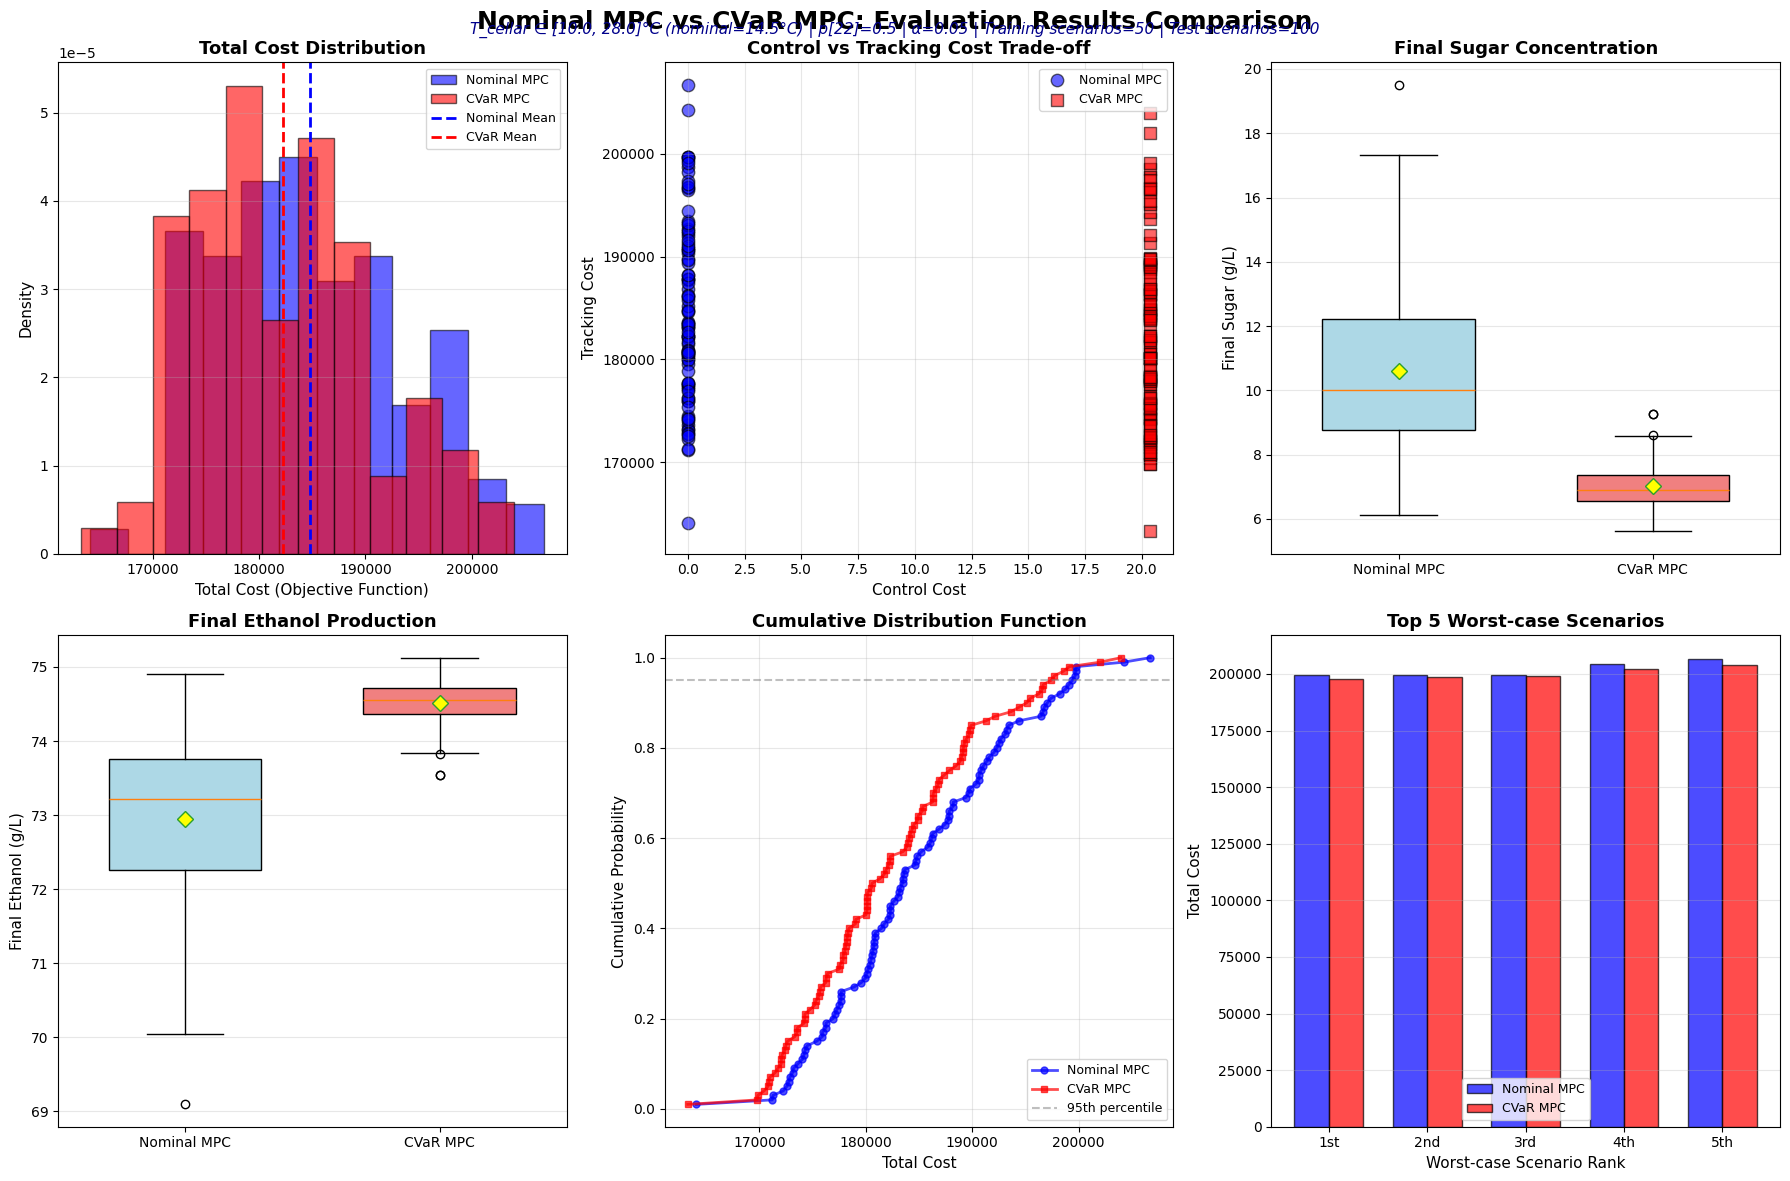

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Nominal MPC vs CVaR MPC: Evaluation Results Comparison', fontsize=18, fontweight='bold')

# Add uncertainty parameters as subtitle
param_text = (f'T_cellar ∈ [{T_cellar_min}, {T_cellar_max}]°C (nominal={T_cellar_nominal}°C) | '
              f'p[22]={p_fred[22]} | α={alpha} | '
              f'Training scenarios={n_training_scenarios} | Test scenarios={n_test_scenarios}')
fig.text(0.5, 0.96, param_text, ha='center', fontsize=11, style='italic', color='darkblue')

# Plot 1: Total Cost Distribution
ax = axes[0, 0]
ax.hist(results_nominal['total_cost'], bins=12, alpha=0.6, color='blue', 
        label='Nominal MPC', edgecolor='black', density=True)
ax.hist(results_cvar['total_cost'], bins=12, alpha=0.6, color='red', 
        label='CVaR MPC', edgecolor='black', density=True)
ax.axvline(np.mean(results_nominal['total_cost']), color='blue', 
           linestyle='--', linewidth=2, label='Nominal Mean')
ax.axvline(np.mean(results_cvar['total_cost']), color='red', 
           linestyle='--', linewidth=2, label='CVaR Mean')
ax.set_xlabel('Total Cost (Objective Function)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Total Cost Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Control Cost vs Tracking Cost
ax = axes[0, 1]
ax.scatter(results_nominal['control_cost'], results_nominal['tracking_cost'], 
           alpha=0.6, s=80, color='blue', marker='o', label='Nominal MPC', edgecolors='black')
ax.scatter(results_cvar['control_cost'], results_cvar['tracking_cost'], 
           alpha=0.6, s=80, color='red', marker='s', label='CVaR MPC', edgecolors='black')
ax.set_xlabel('Control Cost', fontsize=11)
ax.set_ylabel('Tracking Cost', fontsize=11)
ax.set_title('Control vs Tracking Cost Trade-off', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Final Sugar Distribution
ax = axes[0, 2]
positions = [1, 2]
bp = ax.boxplot([results_nominal['final_sugar'], results_cvar['final_sugar']], 
                 positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_xticks(positions)
ax.set_xticklabels(['Nominal MPC', 'CVaR MPC'])
ax.set_ylabel('Final Sugar (g/L)', fontsize=11)
ax.set_title('Final Sugar Concentration', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Final Ethanol Distribution
ax = axes[1, 0]
positions = [1, 2]
bp = ax.boxplot([results_nominal['final_ethanol'], results_cvar['final_ethanol']], 
                 positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_xticks(positions)
ax.set_xticklabels(['Nominal MPC', 'CVaR MPC'])
ax.set_ylabel('Final Ethanol (g/L)', fontsize=11)
ax.set_title('Final Ethanol Production', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 5: CDF of Total Cost
ax = axes[1, 1]
sorted_nom = np.sort(results_nominal['total_cost'])
sorted_cvar = np.sort(results_cvar['total_cost'])
cdf_nom = np.arange(1, len(sorted_nom) + 1) / len(sorted_nom)
cdf_cvar = np.arange(1, len(sorted_cvar) + 1) / len(sorted_cvar)

ax.plot(sorted_nom, cdf_nom, 'b-o', linewidth=2, markersize=5, 
        label='Nominal MPC', alpha=0.7)
ax.plot(sorted_cvar, cdf_cvar, 'r-s', linewidth=2, markersize=5, 
        label='CVaR MPC', alpha=0.7)
ax.axhline(y=0.95, color='gray', linestyle='--', alpha=0.5, label='95th percentile')
ax.set_xlabel('Total Cost', fontsize=11)
ax.set_ylabel('Cumulative Probability', fontsize=11)
ax.set_title('Cumulative Distribution Function', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 6: Worst-case scenarios comparison
ax = axes[1, 2]
worst_indices_nom = np.argsort(results_nominal['total_cost'])[-5:]
worst_indices_cvar = np.argsort(results_cvar['total_cost'])[-5:]

x_pos = np.arange(5)
width = 0.35

ax.bar(x_pos - width/2, results_nominal['total_cost'][worst_indices_nom], 
       width, alpha=0.7, color='blue', label='Nominal MPC', edgecolor='black')
ax.bar(x_pos + width/2, results_cvar['total_cost'][worst_indices_cvar], 
       width, alpha=0.7, color='red', label='CVaR MPC', edgecolor='black')

ax.set_xlabel('Worst-case Scenario Rank', fontsize=11)
ax.set_ylabel('Total Cost', fontsize=11)
ax.set_title('Top 5 Worst-case Scenarios', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save plot to folder
plot_folder = 'part 3 result plots'
os.makedirs(plot_folder, exist_ok=True)

# Generate filename with timestamp and parameters
timestamp_str = datetime.now().strftime('%Y%m%d_%H%M%S')
plot_filename = f"comparison_T{T_cellar_min}-{T_cellar_max}_p22-{p_fred[22]}_alpha{alpha}_{timestamp_str}.png"
plot_path = os.path.join(plot_folder, plot_filename)

plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to: {plot_path}")

plt.show()